In [1]:
import cartopy.crs as ccrs
from cmocean import cm 
from dino import Experiment
from matplotlib import colors
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import cftime as cft    
import xnemogcm as xn
import xgcm
from xesmf import Regridder

In [11]:
path   = "/data/dkamm/nemo_output/DINO/"
dino_exp = Experiment(path, 'DINO_1deg/restart31')

In [12]:
other_dino_exp = Experiment(path, 'regrid_DINO_1_4deg')

In [4]:
emp_self = xr.open_dataset(path + 'regrid_DINO_1_4deg/emp_climatology.nc').rename({'x':'x_c', 'y':'y_c'}).assign_coords({'lat':dino_exp.domain.gphit, 'lon':dino_exp.domain.glamt}).drop_vars(['glamt','gphit'])

In [5]:
emp_self = emp_self.assign(mask=dino_exp.domain.tmask.isel(z_c=0).drop_vars(['glamt', 'gphit', 'gdept_1d', 'gdept_0', 'z_c']))

In [6]:
emp_dummy = other_dino_exp.domain.e1t.rename({'gphit':'lat', 'glamt':'lon'}).to_dataset(name='emp')

In [7]:
emp_dummy = emp_dummy.assign(mask=other_dino_exp.domain.tmask.isel(z_c=0).drop_vars(['glamt', 'gphit', 'gdept_1d', 'gdept_0', 'z_c']))

In [8]:
test = Regridder(emp_self, emp_dummy, method='bilinear', extrap_method="nearest_s2d")

In [9]:
emp_new = test(emp_self)

In [10]:
average = other_dino_exp.grid.average(emp_new, ['X', 'Y'])

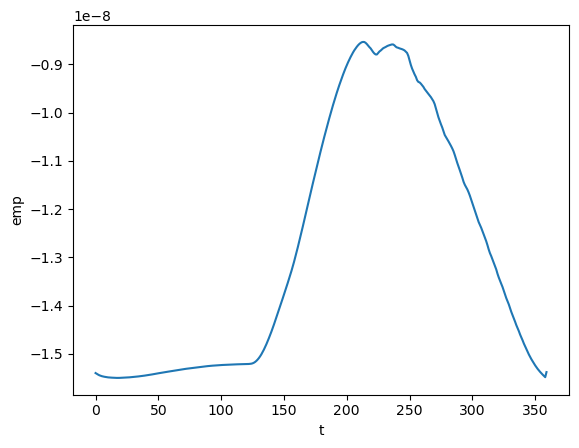

In [11]:
average.emp.plot()

In [12]:
def get_emp(exp, ds, d=20, tolerance=1e-20):
    """
    Compute the EmP-field (Evaporation - Precipitation).
    To ensure a conserved volume the global mean EmP should be zero.
    The mean is removed from the maximum precipitation in the tropics
    with a tapering such that the prescribed freshwater flux in
    high latitudes does not alter deep water formation.
    Tapering:  F(y) = A * (cos( pi * y / d ))    if |y| <= d
                    = 0                          else

    with        A   = emp_mean * L / (2 * d)
    """
    emp         = ds.emp
    
    emp_mean    = exp.grid.average(emp, ['X', 'Y'])
    taper       = ( 
        (abs(exp.domain.gphit) <= 20)                  # one in tropics, zero elsewhere
        * (np.cos( np.pi * exp.domain.gphit / d) + 1)  # tapering-function
    )
    taper_mean  = exp.grid.average(taper, ['X', 'Y'])
    while abs(emp_mean).max().values > tolerance:  
        emp_star = emp - emp_mean * taper / taper_mean
        emp      = emp_star
        emp_mean = exp.grid.average(emp_star, ['X', 'Y'])
    return(emp_star)

In [13]:
removed_mean = get_emp(other_dino_exp, emp_new)

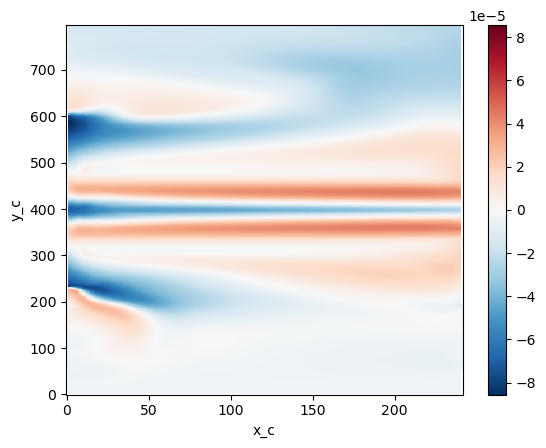

In [14]:
removed_mean.isel(t=-1).plot()

In [18]:
ds = removed_mean.to_dataset(name='emp').drop_vars([
    'x_c',
    'y_c',
    'gphit',
    'glamt',
    'lat',
    'lon',
]).rename({'x_c':'x', 'y_c':'y'})

In [20]:
#ds.to_netcdf('emp_climatology_1_4deg.nc', encoding={'emp': {'_FillValue': False}})

In [13]:
new_restart = dino_exp.regrid_restart(other_dino_exp)

/home/dkamm/miniconda3/envs/nemo_env/lib/python3.9/site-packages/xesmf/backend.py:41: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')


In [20]:
new_restart

<xarray.Dataset>
Dimensions:       (time_counter: 1, y: 797, x: 242, nav_lev: 36)
Coordinates:
  * nav_lev       (nav_lev) float32 5.034 15.32 25.96 ... 3.757e+03 4.253e+03
  * time_counter  (time_counter) float32 1.843e+07
    lat           (y, x) float64 -70.02 -70.02 -70.02 ... 70.02 70.02 70.02
    lon           (y, x) float64 -0.125 0.125 0.375 0.625 ... 59.62 59.88 60.12
Dimensions without coordinates: y, x
Data variables: (12/29)
    kt            float64 0.0
    ndastp        float64 0.0
    adatrj        float64 0.0
    ntime         float64 0.0
    utau_b        (time_counter, y, x) float64 dask.array<chunksize=(1, 17, 21), meta=np.ndarray>
    vtau_b        (time_counter, y, x) float64 dask.array<chunksize=(1, 17, 21), meta=np.ndarray>
    ...            ...
    sshn          (time_counter, y, x) float64 dask.array<chunksize=(1, 17, 21), meta=np.ndarray>
    un            (time_counter, nav_lev, y, x) float64 dask.array<chunksize=(1, 36, 17, 21), meta=np.ndarray>
    vn            (time_counter, nav_lev, y, x) float64 dask.array<chunksize=(1, 36, 17, 21), meta=np.ndarray>
    tn            (time_counter, nav_lev, y, x) float64 dask.array<chunksize=(1, 36, 17, 21), meta=np.ndarray>
    sn            (time_counter, nav_lev, y, x) float64 dask.array<chunksize=(1, 36, 17, 21), meta=np.ndarray>
    rhop          (time_counter, nav_lev, y, x) float64 dask.array<chunksize=(1, 36, 17, 21), meta=np.ndarray>

In [19]:
new_restart['adatrj'] = 0.
new_restart['ndastp'] = 0.
new_restart['kt'] = 0.

In [21]:
new_restart.to_netcdf('restart_1_4deg.nc')

KeyboardInterrupt: 

In [5]:
temperature = (new_restart.tn + new_restart.tb) / 2     

In [6]:
salinity = (new_restart.sn + new_restart.sb) / 2

In [7]:
temperature_ds = temperature.to_dataset(name='votemper').drop_vars([
    'nav_lev',
    'time_counter',
    'lat',
    'lon',
]).rename({'nav_lev':'z'}).squeeze()

In [8]:
salinity_ds = salinity.to_dataset(name='vosaline').drop_vars([
    'nav_lev',
    'time_counter',
    'lat',
    'lon',
]).rename({'nav_lev':'z'}).squeeze()

In [9]:
ts_ds = xr.merge([salinity_ds, temperature_ds])

In [10]:
ts_ds.to_netcdf('ts_1_4deg.nc', encoding={'votemper': {'_FillValue': False}, 'vosaline': {'_FillValue': False}})

In [30]:
xr.open_dataset("emp_climatology.nc").emp.isel(t=0).values

array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan, -3.08313226e-06, -3.08675624e-06, ...,
        -3.39676835e-06, -3.40284605e-06,             nan],
       [            nan, -2.98975701e-06, -2.99186868e-06, ...,
        -3.33962448e-06, -3.35410389e-06,             nan],
       ...,
       [            nan, -1.47775132e-05, -1.48497581e-05, ...,
        -2.45721656e-05, -2.48012702e-05,             nan],
       [            nan, -1.48535224e-05, -1.49240346e-05, ...,
        -2.44853218e-05, -2.46205669e-05,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan]])

In [2]:
path   = "/data/dkamm/nemo_output/DINO/"

In [3]:
abort = xr.open_dataset(path + 'output.abort.nc')

In [14]:
abort = abort.rename({'x':'lon', 'y':'lat'})

In [46]:
abort.vozocrtx.isel(nav_lev=0).min()

<xarray.DataArray 'vozocrtx' ()>
array(-0.01574139)
Coordinates:
    nav_lev  float32 5.034

In [76]:
other_dino_exp.domain.tmask

<xarray.DataArray 'tmask' (z_c: 36, y_c: 797, x_c: 242)>
dask.array<getitem, shape=(36, 797, 242), dtype=int8, chunksize=(36, 67, 81), chunktype=numpy.ndarray>
Coordinates:
    glamt     (y_c, x_c) float64 dask.array<chunksize=(67, 81), meta=np.ndarray>
    gphit     (y_c, x_c) float64 dask.array<chunksize=(67, 81), meta=np.ndarray>
    gdept_1d  (z_c) float64 dask.array<chunksize=(36,), meta=np.ndarray>
    gdept_0   (z_c, y_c, x_c) float64 dask.array<chunksize=(36, 67, 81), meta=np.ndarray>
  * x_c       (x_c) int64 0 1 2 3 4 5 6 7 8 ... 234 235 236 237 238 239 240 241
  * y_c       (y_c) int64 0 1 2 3 4 5 6 7 8 ... 789 790 791 792 793 794 795 796
  * z_c       (z_c) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35

In [4]:
init = xr.open_dataset('t_s_1_4deg.nc')

In [5]:
init['mask'] = (('z','y','x'), other_dino_exp.domain.tmask.values)

In [6]:
init = init.where(init.mask==1)

In [7]:
init = init.ffill('z')

In [11]:
init = init.ffill('x').bfill('x')

In [13]:
init = init.ffill('y').bfill('y')

In [20]:
init.drop_vars('mask').to_netcdf('ts_1_4deg.nc')

In [2]:
testo = xr.open_dataset('/data/dkamm/nemo_output/DINO/DINO_1ts_grid_T.nc')

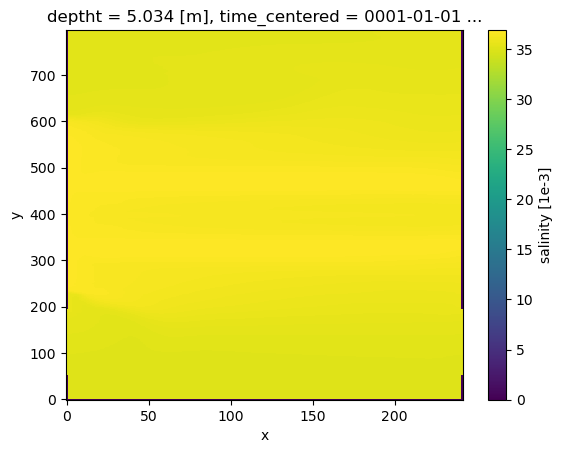

In [5]:
testo.soce.isel(deptht=0).plot()

In [43]:
testo.soce.isel(deptht=0).values

array([[[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      , 35.028255, 35.028255, ..., 35.03116 , 35.03116 ,
          0.      ],
        [ 0.      , 35.028255, 35.028255, ..., 35.03116 , 35.03116 ,
          0.      ],
        ...,
        [ 0.      , 35.24602 , 35.24602 , ..., 35.327568, 35.327568,
          0.      ],
        [ 0.      , 35.24602 , 35.24602 , ..., 35.327568, 35.327568,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ]]], dtype=float32)

In [11]:
path   = "/data/dkamm/nemo_output/DINO/"
dino_exp = Experiment(path, 'DINO_1_4deg_bilap/restart0')

In [12]:
other_dino_exp = Experiment(path, 'DINO_1_16deg_regrid')

In [15]:
new_restart = dino_exp.regrid_restart(other_dino_exp)

/home/dkamm/miniconda3/envs/nemo_env/lib/python3.9/site-packages/xesmf/backend.py:41: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')


In [23]:
new_restart = new_restart.chunk(chunks={'nav_lev':1})

In [33]:
new_restart

<xarray.Dataset>
Dimensions:       (y: 3183, x: 962, nav_lev: 36)
Coordinates:
  * nav_lev       (nav_lev) float32 5.034 15.32 25.96 ... 3.757e+03 4.253e+03
    time_counter  float32 4.32e+05
    lat           (y, x) float64 dask.array<chunksize=(3183, 962), meta=np.ndarray>
    lon           (y, x) float64 dask.array<chunksize=(3183, 962), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables: (12/29)
    kt            float64 0.0
    ndastp        float64 0.0
    adatrj        float64 0.0
    ntime         float64 ...
    utau_b        (y, x) float64 dask.array<chunksize=(795, 240), meta=np.ndarray>
    vtau_b        (y, x) float64 dask.array<chunksize=(795, 240), meta=np.ndarray>
    ...            ...
    sshn          (y, x) float64 dask.array<chunksize=(795, 240), meta=np.ndarray>
    un            (nav_lev, y, x) float64 dask.array<chunksize=(1, 795, 240), meta=np.ndarray>
    vn            (nav_lev, y, x) float64 dask.array<chunksize=(1, 795, 240), meta=np.ndarray>
    tn            (nav_lev, y, x) float64 dask.array<chunksize=(1, 795, 240), meta=np.ndarray>
    sn            (nav_lev, y, x) float64 dask.array<chunksize=(1, 795, 240), meta=np.ndarray>
    rhop          (nav_lev, y, x) float64 dask.array<chunksize=(1, 795, 240), meta=np.ndarray>

In [25]:
new_restart['adatrj'] = 0.
new_restart['ndastp'] = 0.
new_restart['kt'] = 0.

In [34]:
new_restart.to_netcdf('restart_1_16deg.nc')

MemoryError: Unable to allocate 5.82 MiB for an array with shape (763199,) and data type int64

In [2]:
emp = xr.open_dataset('emp_climatology_1_4deg.nc')

In [5]:
emp_plot = emp.isel(t=30).load()

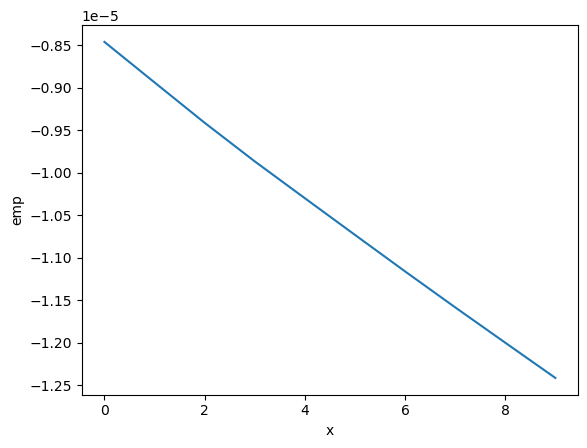

In [10]:
emp_plot.emp.isel(x=slice(120,130), y=610).plot()